# Testing different ML models to predict gene set scores from surface protein data

In this notebook different reggressors (RandomForestRegressor, GradientBoostingReggressor, CatBoostRegressor) are tested to predict gene set scores from CLR tranformed surface protein data. 

All three reggressors, Random Forest, Gradient boosting and Catboost, are ensembles of decision trees. Random forest is a very popular algorithm, having high accuracy and working efficiently with high dimensional data. While Random forest aggregates results of multiple independently built  decision trees, gradient boosting methods built decision trees so, that each new tree aims to correct the errors of the previously fitted ones and this way gradually improves the model. Consequently, gradient boosting methods could be more accurate than Random forest, but are more prone to overfitting. Regressors produce feature importances, which are here used to find important surface protein markers for studied gene set scores, that are representative for specific NK cell subtype. Used gene sets were collected from Melsen et al., (2022) paper. Not all genes identified in Yang study were found in Neurips data, so gene sets are not completely comparable. Additionally, analyzed gene sets were relatively small and not all genes were highly expressed in Neurips data, which might affect to analysis done in this notebook. 

Neurips data was analysed at 4 different sites. Protein data used in this notebooks is limited to only sites 1 and 4, since it was earlier observed that these sites are showing better antibody signals compared to sites 2 and 3. Only NK cells from samples analyzed at sites 1 and 4 are selected for analysis. 


5 common clusters were found in Melsen and Yang (+Crinier) datasets; 

1. Proliferating NK cells
2. CD56dim GZMK-
3. CD56dim GZMK+ (transitional subset between CD56bright and CD56dim NK cells)
4. CD56bright
5. lymhoid tissue-resident NK cells (lt-NK)

Here, gene set for cd56bright NK cells is explored. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scvi
import scanpy as sc
import seaborn as sb


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#markers

#Proliferating
prolif = ['S100A4', 'S100A6', 'KLRC2', 'IL32', 'GZMH', 'GNLY']

#CD56dim GZMK-
cd56dim_gzmk_neg= ['S100A4', 'S100A6', 'ACTB', 'ACTG1', 'CORO1A', 'PFN1', 'GZMB'] #lower expression of GZMB in gzmk_pos cluster, so marker added in this gene set

#CD56dim GZMK+
cd56dim_gzmk_pos = ['GZMK', 'SELL']

#CD56bright
cd56bright= ['NCAM1', 'KIT', 'SELL', 'CD2', 'IL7R', 'KLRC1']
#cd56bright_prot= ['CD56', 'CD62L', "CD2_prot", 'CD127']  #CD117 ab not used in this dataset

#lt-NK
lt_nk= ['CCL3', 'CCL4', 'XCL1', 'GZMK', 'CD160', 'DUSP2', 'CXCR4', 'BTG1']


In [3]:
#loading Neurips dataset
adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [4]:
adata_neurips

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [5]:
adata_neurips.obs['Site'].unique().tolist()

['site4', 'site3', 'site1', 'site2']

In [6]:
#selecting only sites 1 and 4 (good ab signals), from Neurips dataset

eg=adata_neurips[(adata_neurips.obs['Site'] == "site4") | (adata_neurips.obs['Site'] == "site1")].copy() 

In [7]:
eg.obs['Site'].unique().tolist()

['site4', 'site1']

In [8]:
#selecting only NK cells using Neurips annotations

eg_nk = eg[(eg.obs['cell_type'] == "NK") | (eg.obs['cell_type'] == "NK CD158e1+")].copy()   


In [9]:
eg_nk.obs['cell_type'].unique().tolist()

['NK', 'NK CD158e1+']

In [10]:
#This includes now NK cellsfrom site 1 and 4
eg_nk

AnnData object with n_obs × n_vars = 2640 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

## Calculating gene scores for gene sets

In [11]:
markers = cd56bright

In [12]:
markers

['NCAM1', 'KIT', 'SELL', 'CD2', 'IL7R', 'KLRC1']

In [13]:
#calculating scores for gene set

sc.tl.score_genes(eg_nk, markers, score_name = 'marker_score')

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [14]:
eg_nk.obs['marker_score']

GTAGTACCAATCCTTT-1-s4d1   -0.356433
CTGTGGGTCATGCGGC-1-s4d1   -0.351946
GCAACATTCGCAAGAG-1-s4d1   -0.218289
TCACGGGTCGCACGAC-1-s4d1   -0.301242
CGCCAGAAGACCATTC-1-s4d1   -0.342014
                             ...   
ATCATTCGTCCAATCA-1-s1d3    0.162506
ACATTTCCAGCAGTGA-1-s1d3   -0.127642
TGAGACTTCCTTCAGC-1-s1d3   -0.228768
GAGATGGTCCGCCTAT-1-s1d3   -0.348412
ACCTGTCTCACAGTGT-1-s1d3    0.254791
Name: marker_score, Length: 2640, dtype: float64

In [15]:
prot = eg_nk.obsm['protein_expression_clr_neurips']

In [16]:
#dropping columns containing only zeros

prot = prot.loc[:, (prot!=0).any(axis=0)]

In [17]:
#Summary statistics

prot.describe()

CD86        CD274        CD270        CD155        CD112  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000   
mean      0.259739     1.044477     1.077427     0.575894     0.826136   
std       0.328835     0.675683     0.335722     0.379068     0.415217   
min       0.000000     0.000000     0.166149     0.000000     0.000000   
25%       0.000000     0.453643     0.856802     0.306698     0.505917   
50%       0.000000     1.001407     1.063974     0.541080     0.766577   
75%       0.378666     1.491603     1.311364     0.890243     1.144269   
max       4.037784     7.179674     6.503963     3.066146     2.308017   

              CD47         CD48         CD40        CD154         CD52  ...  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000  ...   
mean      1.593414     1.468572     0.757240     0.989188     0.785021  ...   
std       0.436319     0.447961     0.374219     0.417811     0.421535  ...   
min       0.349275     0.201874     0.000000     0.000000     0.000000  ...   
25%       1.303571     1.151323     0.512721     0.663922     0.512170  ...   
50%       1.560743     1.418692     0.749707     0.925184     0.735717  ...   
75%       1.852154     1.726866     1.024682     1.323007     1.013739  ...   
max       3.565268     4.167115     2.040997     2.384986     2.846132  ...   

              CD94        CD162        CD85j         CD23        CD328  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000   
mean      2.695500     1.842853     0.708465     0.999731     2.870358   
std       1.222390     0.656122     0.419833     0.419200     0.942209   
min       0.257817     0.000000     0.000000     0.081182     0.000000   
25%       1.660982     1.407198     0.391222     0.657651     2.332854   
50%       2.591687     1.879785     0.671706     0.958123     2.948787   
75%       3.670459     2.322979     0.984231     1.332566     3.517752   
max       5.781869     4.388661     2.238449     3.030348     5.379574   

             HLA-E         CD82        CD101         CD88        CD224  
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000  
mean      1.253904     0.504434     0.574611     0.820453     0.738894  
std       0.366789     0.279724     0.305433     0.321915     0.430546  
min       0.204475     0.000000     0.000000     0.000000     0.000000  
25%       0.993845     0.353792     0.329073     0.605141     0.430053  
50%       1.251529     0.492675     0.519947     0.809714     0.729806  
75%       1.482333     0.614600     0.728330     1.054625     1.000442  
max       2.666251     3.958134     2.975896     3.458393     2.980588  

[8 rows x 134 columns]

- Protein counts are already CLR normalized and appear to have the same scale, so no standardization step is needed.

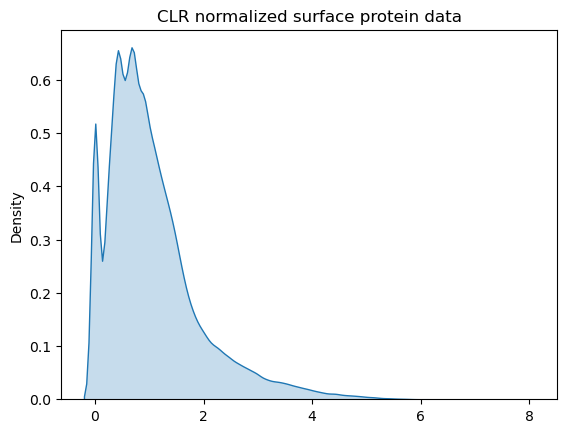

In [18]:
flatten_df = prot.to_numpy().flatten()

sb.kdeplot(flatten_df, fill = True) ; 


plt.title("CLR normalized surface protein data") ;

In [19]:
score_yang = eg_nk.obs['marker_score']

In [20]:
score_yang

GTAGTACCAATCCTTT-1-s4d1   -0.356433
CTGTGGGTCATGCGGC-1-s4d1   -0.351946
GCAACATTCGCAAGAG-1-s4d1   -0.218289
TCACGGGTCGCACGAC-1-s4d1   -0.301242
CGCCAGAAGACCATTC-1-s4d1   -0.342014
                             ...   
ATCATTCGTCCAATCA-1-s1d3    0.162506
ACATTTCCAGCAGTGA-1-s1d3   -0.127642
TGAGACTTCCTTCAGC-1-s1d3   -0.228768
GAGATGGTCCGCCTAT-1-s1d3   -0.348412
ACCTGTCTCACAGTGT-1-s1d3    0.254791
Name: marker_score, Length: 2640, dtype: float64

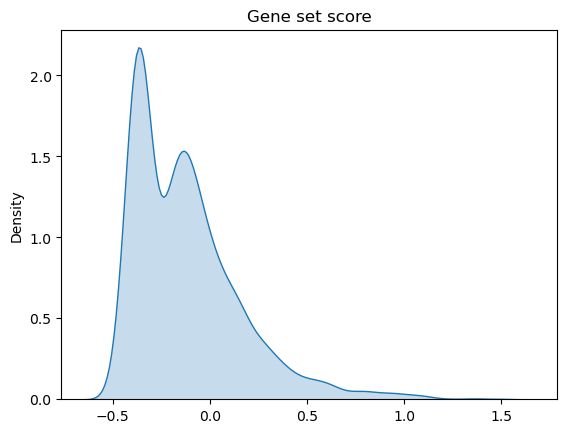

In [21]:
flatten_df1 = score_yang.to_numpy().flatten()

sb.kdeplot(flatten_df1, fill = True) ; 

plt.title("Gene set score") ;

In [22]:
#Creating df containign surface protein data + scores for gene sets

a = score_yang
b = prot

df =pd.concat([a, b], axis=1)


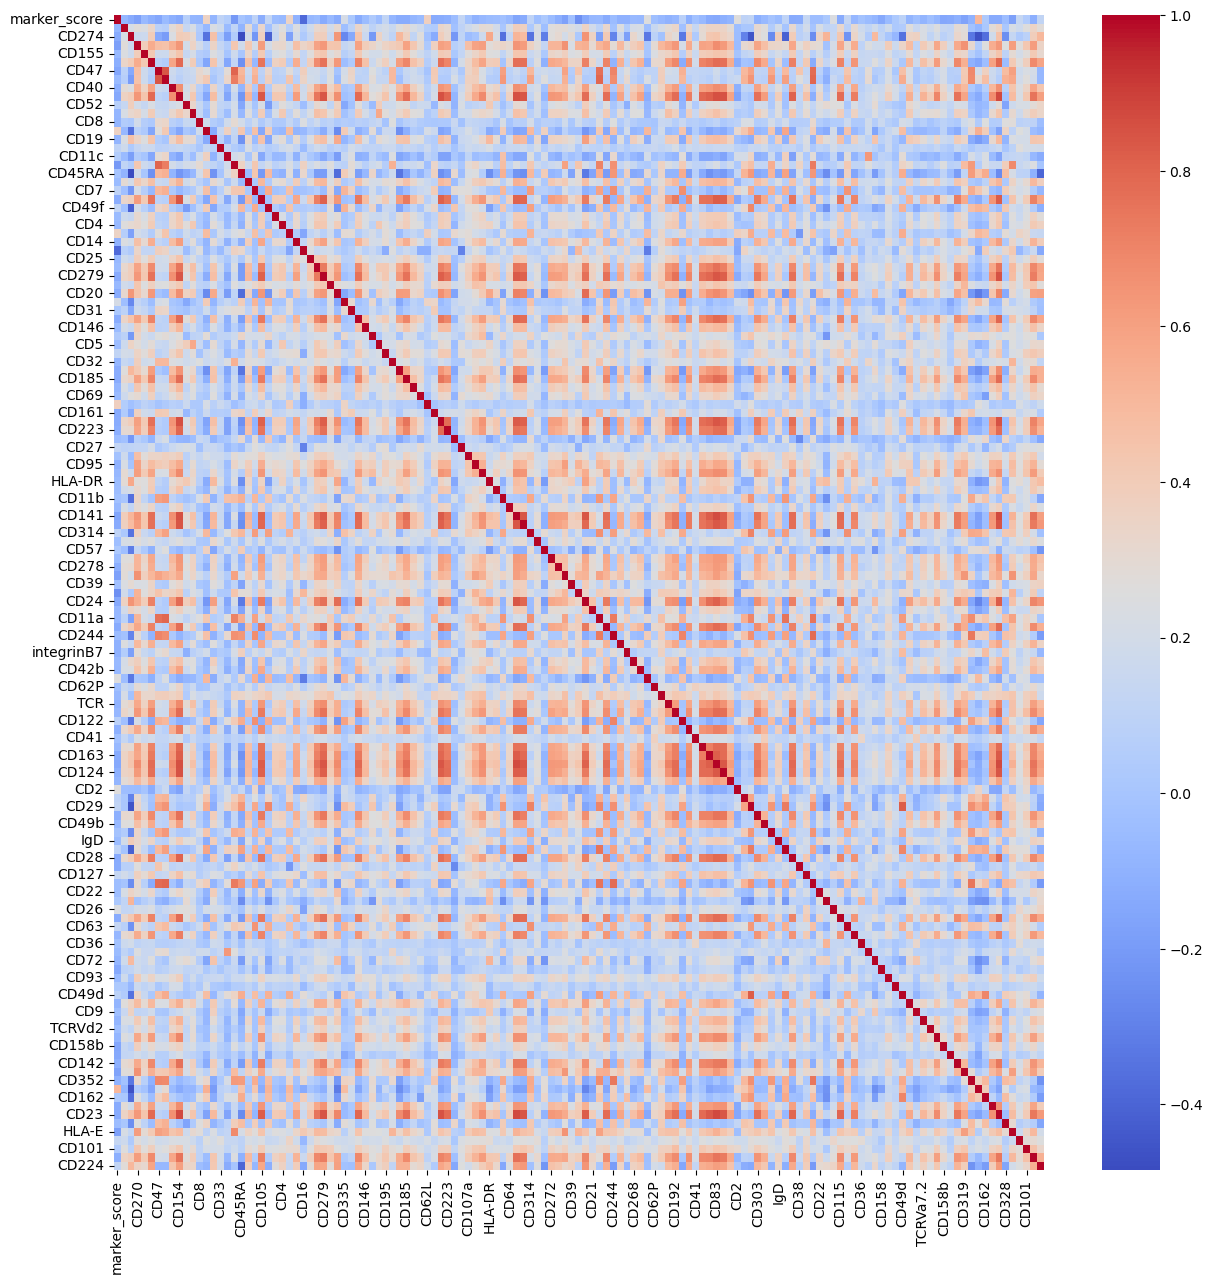

In [23]:
plt.figure(figsize=(15,15))
sb.heatmap(data=df.corr(),cmap='coolwarm')
plt.show()

- According to correlation matrix above, variables are mostly independent and there is no severe multicollinearity problem in the data.

## 1. RandomForestRegressor

In [24]:
#Random forest

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params = {#'bootstrap': [True, False],
 'max_depth': [3,5,7],
 #'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
 'min_samples_leaf': [2, 5, 10],
 #'min_samples_split': [2, 5, 10] ,
 #'n_estimators': [10, 50, 100]
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(RandomForestRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)
    

Mean squared error: 0.03 R2 score: 0.48


In [25]:
#Mean training scores

print(mean_train_score)

[array([-0.04014919, -0.04034264, -0.04029943, -0.0292051 , -0.02986726,
       -0.03125046, -0.0209144 , -0.02238726, -0.02575419])]


In [26]:
# The best score and parameters

print(result.best_score_)
print(result.best_params_)

-0.04033960350394588
{'max_depth': 7, 'min_samples_leaf': 5}


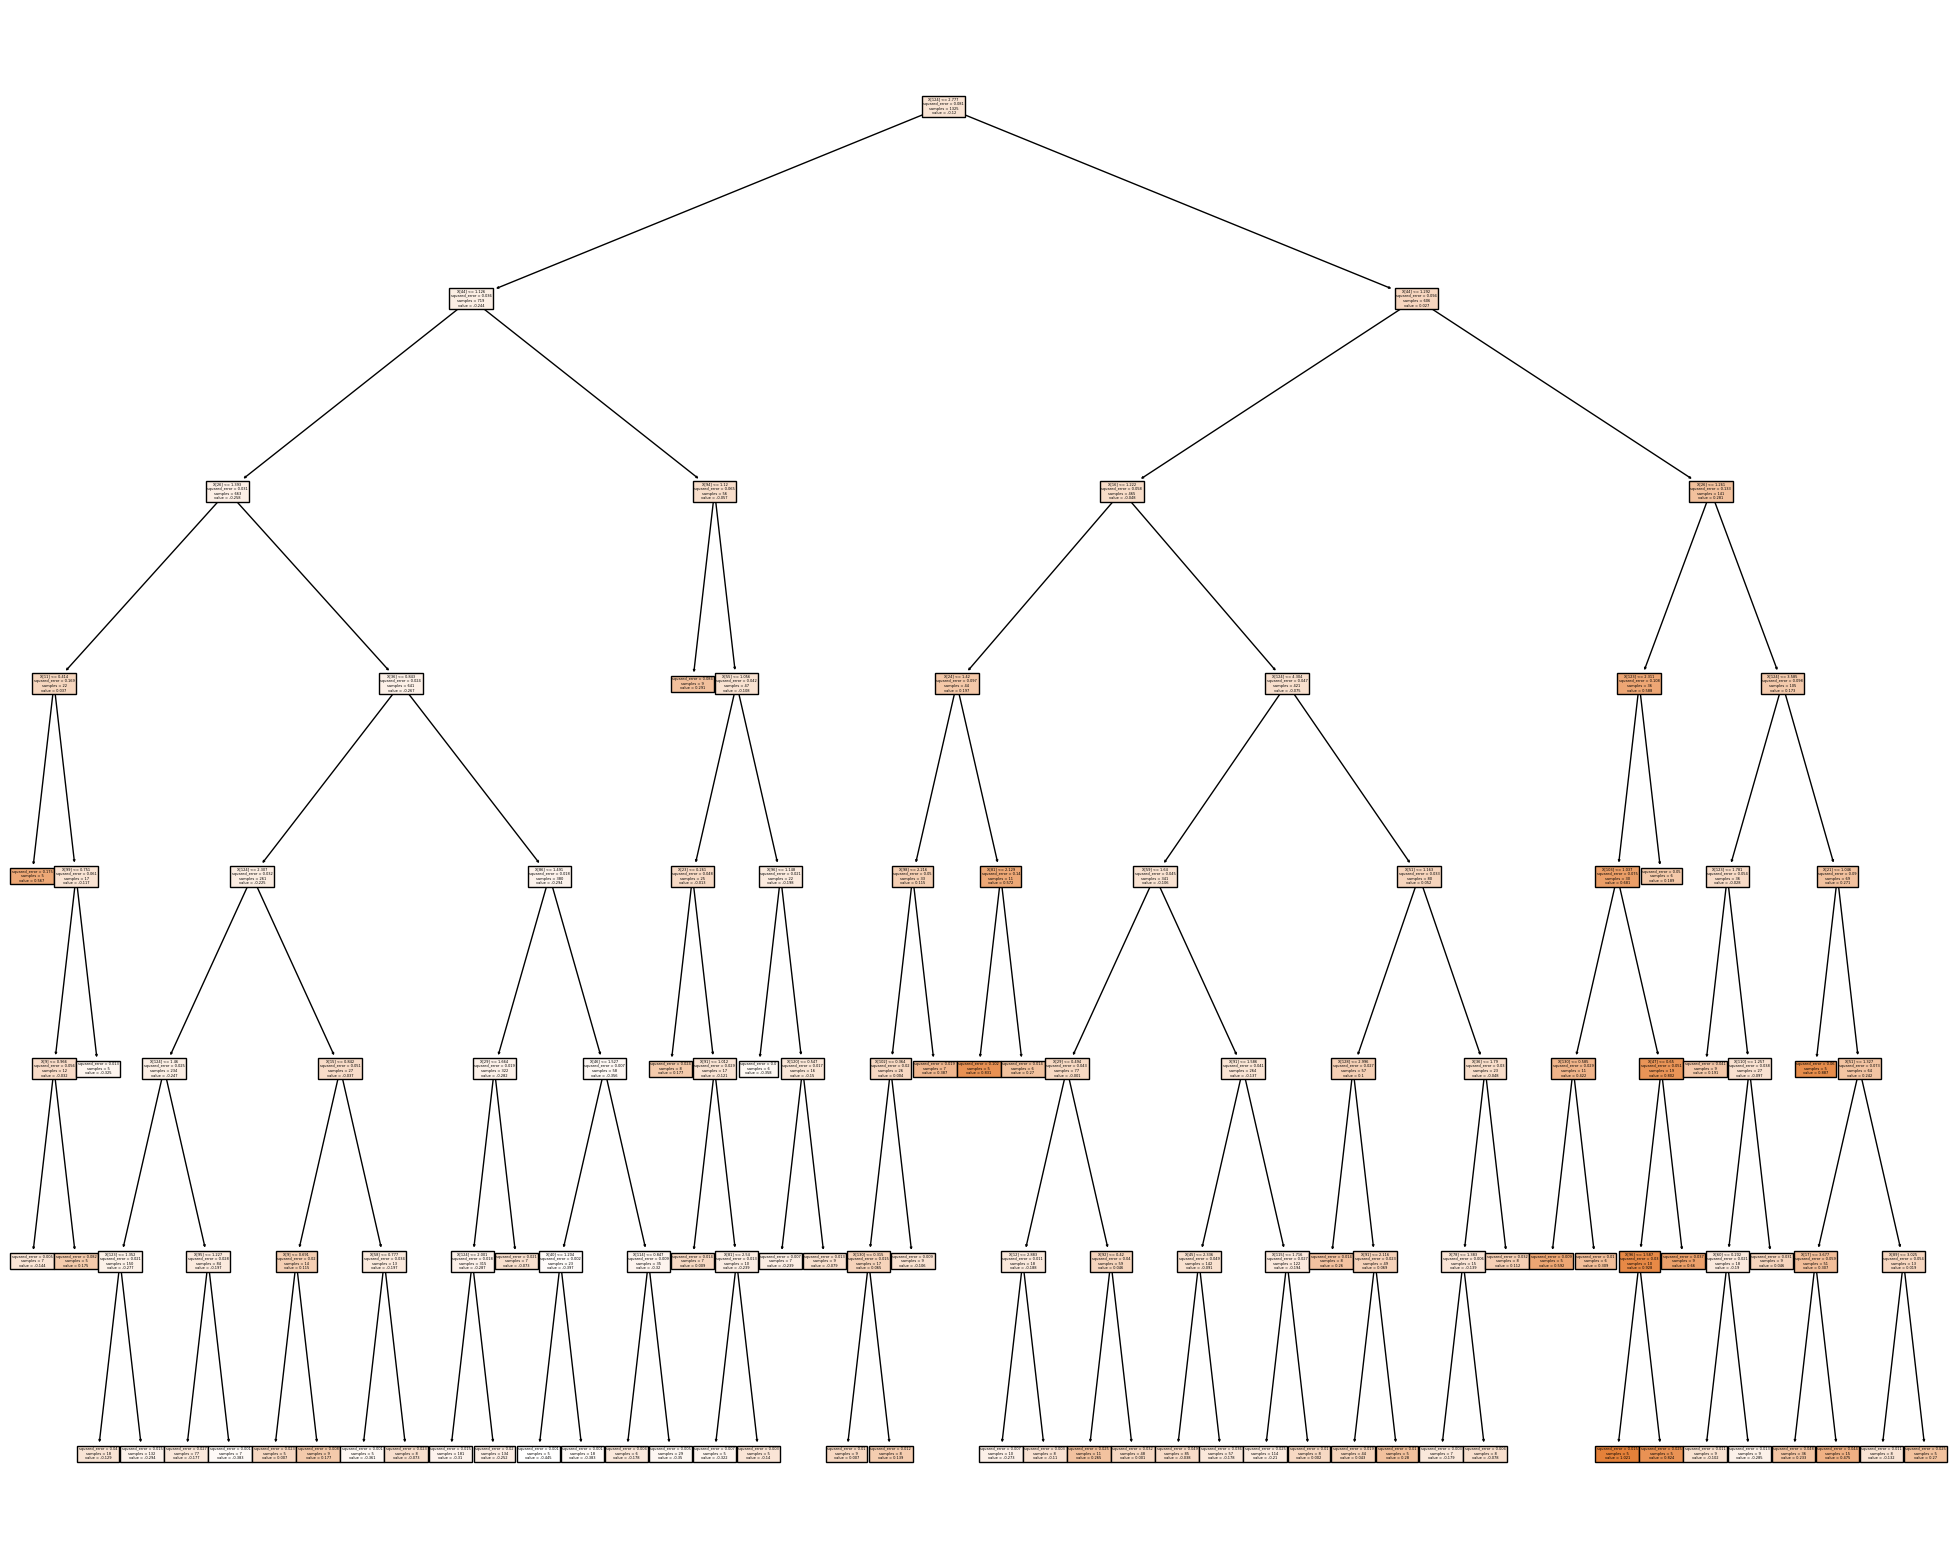

In [27]:
from sklearn import tree

plt.figure(figsize=(25, 20)) # Resize figure
tree.plot_tree(best_model.estimators_[0], filled = True) ;

plt.show()

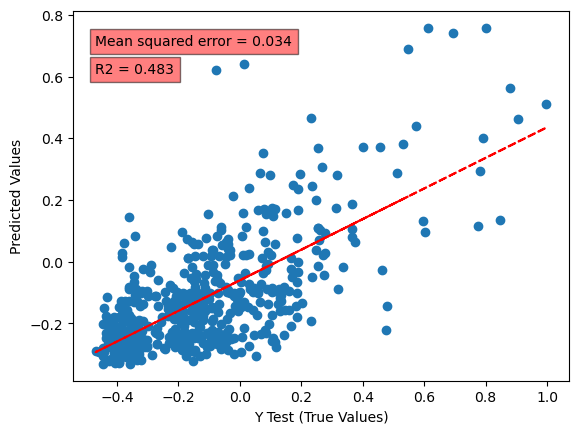

In [58]:
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

plt.annotate("Mean squared error = {:.3f}".format(MSE), (-0.47, 0.7), bbox = dict(facecolor = 'red', alpha = 0.5))

plt.annotate("R2 = {:.3f}".format(R2), (-0.47, 0.61), bbox = dict(facecolor = 'red', alpha = 0.5))


plt.show()

<AxesSubplot: xlabel='marker_score', ylabel='Density'>

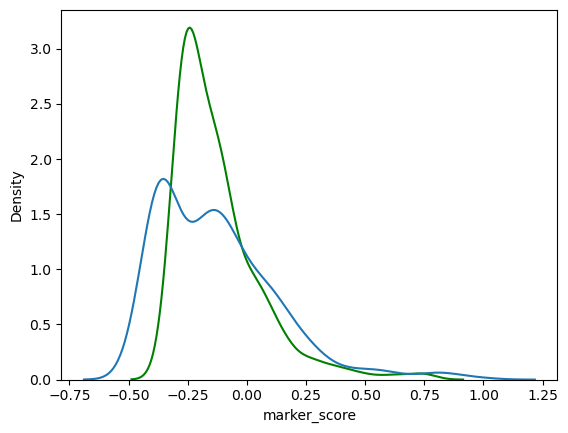

In [37]:
sb.kdeplot(y_pred, color = "g") #predicted values
sb.kdeplot(y_test) #observed values

In [38]:
#Feature importances

importances_rf = best_model.feature_importances_
importances_rf = pd.Series(importances_rf, index=prot.columns)
importances_rf=importances_rf.sort_values(ascending=False)

print(importances_rf.head(10))

CD94         0.339617
CD62L        0.133314
CD16         0.068223
HLA-A-B-C    0.053047
CD352        0.033988
CD56         0.022826
CD44         0.021669
CD45RA       0.017695
CD26         0.012322
CD45         0.011753
dtype: float64


In [39]:
#df from the top 20 important markers
importances_rf=pd.DataFrame(importances_rf)
importances_rf_top=importances_rf[0:20]
importances_rf_top=importances_rf_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


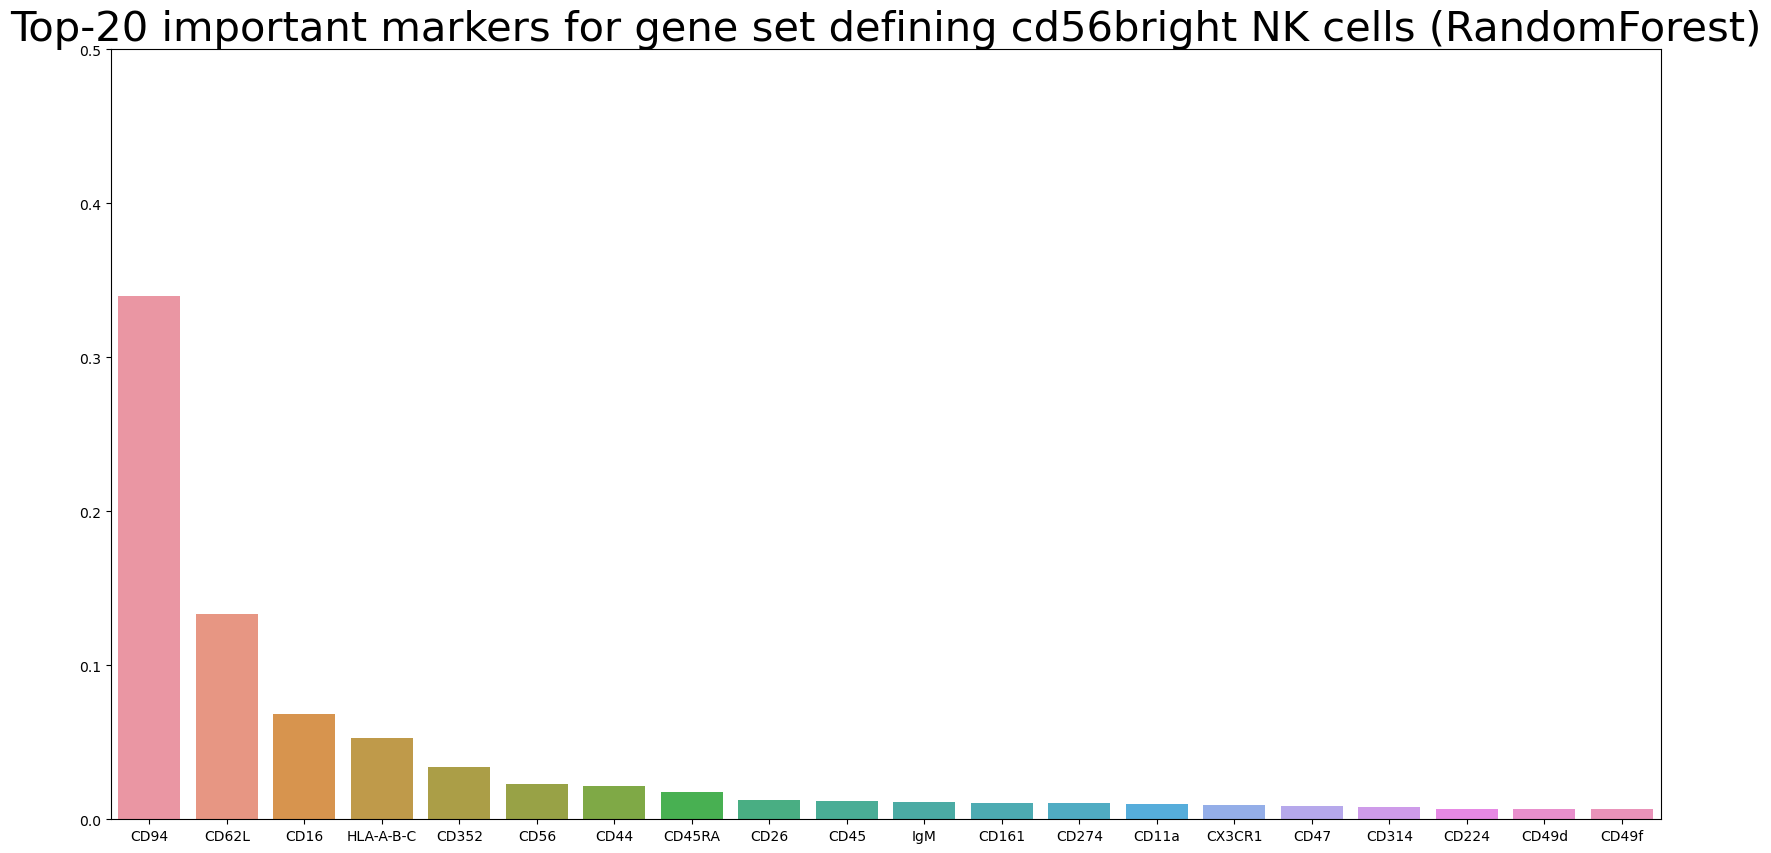

In [55]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.5)
a=sb.barplot(data=importances_rf_top)

plt.title("Top-20 important markers for gene set defining cd56bright NK cells (RandomForest)", fontsize = 30) ;


## 2. Dummy Reggressor

In [30]:
from sklearn.dummy import DummyRegressor

X = df.iloc[:, 1:]
y = df['marker_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
  
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [32]:

print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

Mean squared error (dummy): 0.07
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.02


## 3. GragientBoostingRegressor

In [59]:
#Gradient boosting regressor

from sklearn.ensemble import GradientBoostingRegressor

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params =  {'max_depth': [3,5,7],
          'min_samples_leaf': [2, 5, 10]}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(GradientBoostingRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_gbr = result.best_estimator_
y_pred = best_model_gbr.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.03 R2 score: 0.48


In [60]:
print(mean_train_score)

[array([-0.02091463, -0.02075051, -0.02116794, -0.00598359, -0.0063501 ,
       -0.00782763, -0.00061275, -0.00087467, -0.00193578])]


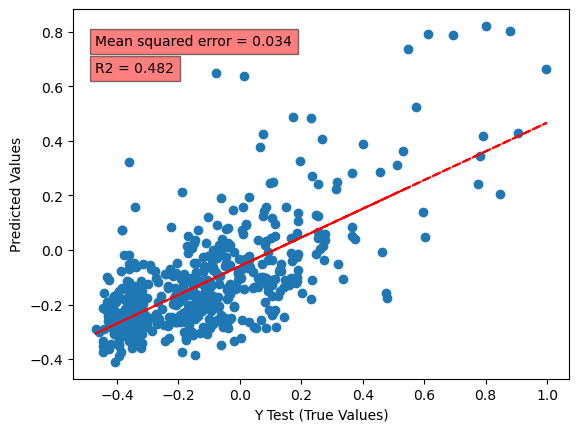

In [65]:
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

plt.annotate("Mean squared error = {:.3f}".format(MSE), (-0.47, 0.75), bbox = dict(facecolor = 'red', alpha = 0.5))

plt.annotate("R2 = {:.3f}".format(R2), (-0.47, 0.65), bbox = dict(facecolor = 'red', alpha = 0.5))


plt.show()

<AxesSubplot: xlabel='marker_score', ylabel='Density'>

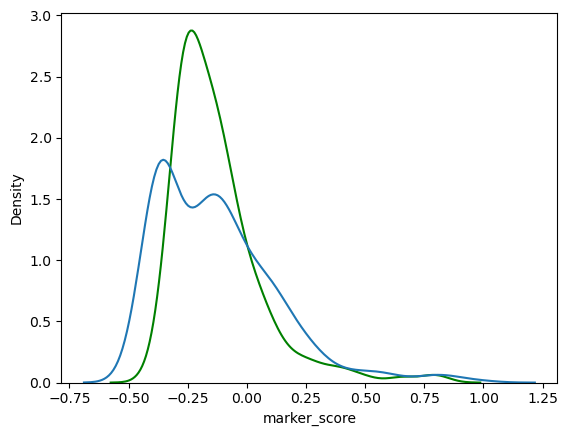

In [45]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [46]:
importances_gbr = best_model_gbr.feature_importances_
importances_gbr = pd.Series(importances_gbr, index=prot.columns)
importances_gbr=importances_gbr.sort_values(ascending=False)

print(importances_gbr.head(10))

CD94         0.326735
CD62L        0.143091
CD16         0.074489
HLA-A-B-C    0.051504
CD44         0.048733
CD352        0.043266
CD56         0.027102
CD45         0.020952
CD11a        0.019734
CD161        0.017265
dtype: float64


In [47]:
#df from the top 20 important markers
importances_gbr=pd.DataFrame(importances_gbr)
importances_gbr_top=importances_gbr[0:20]
importances_gbr_top=importances_gbr_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


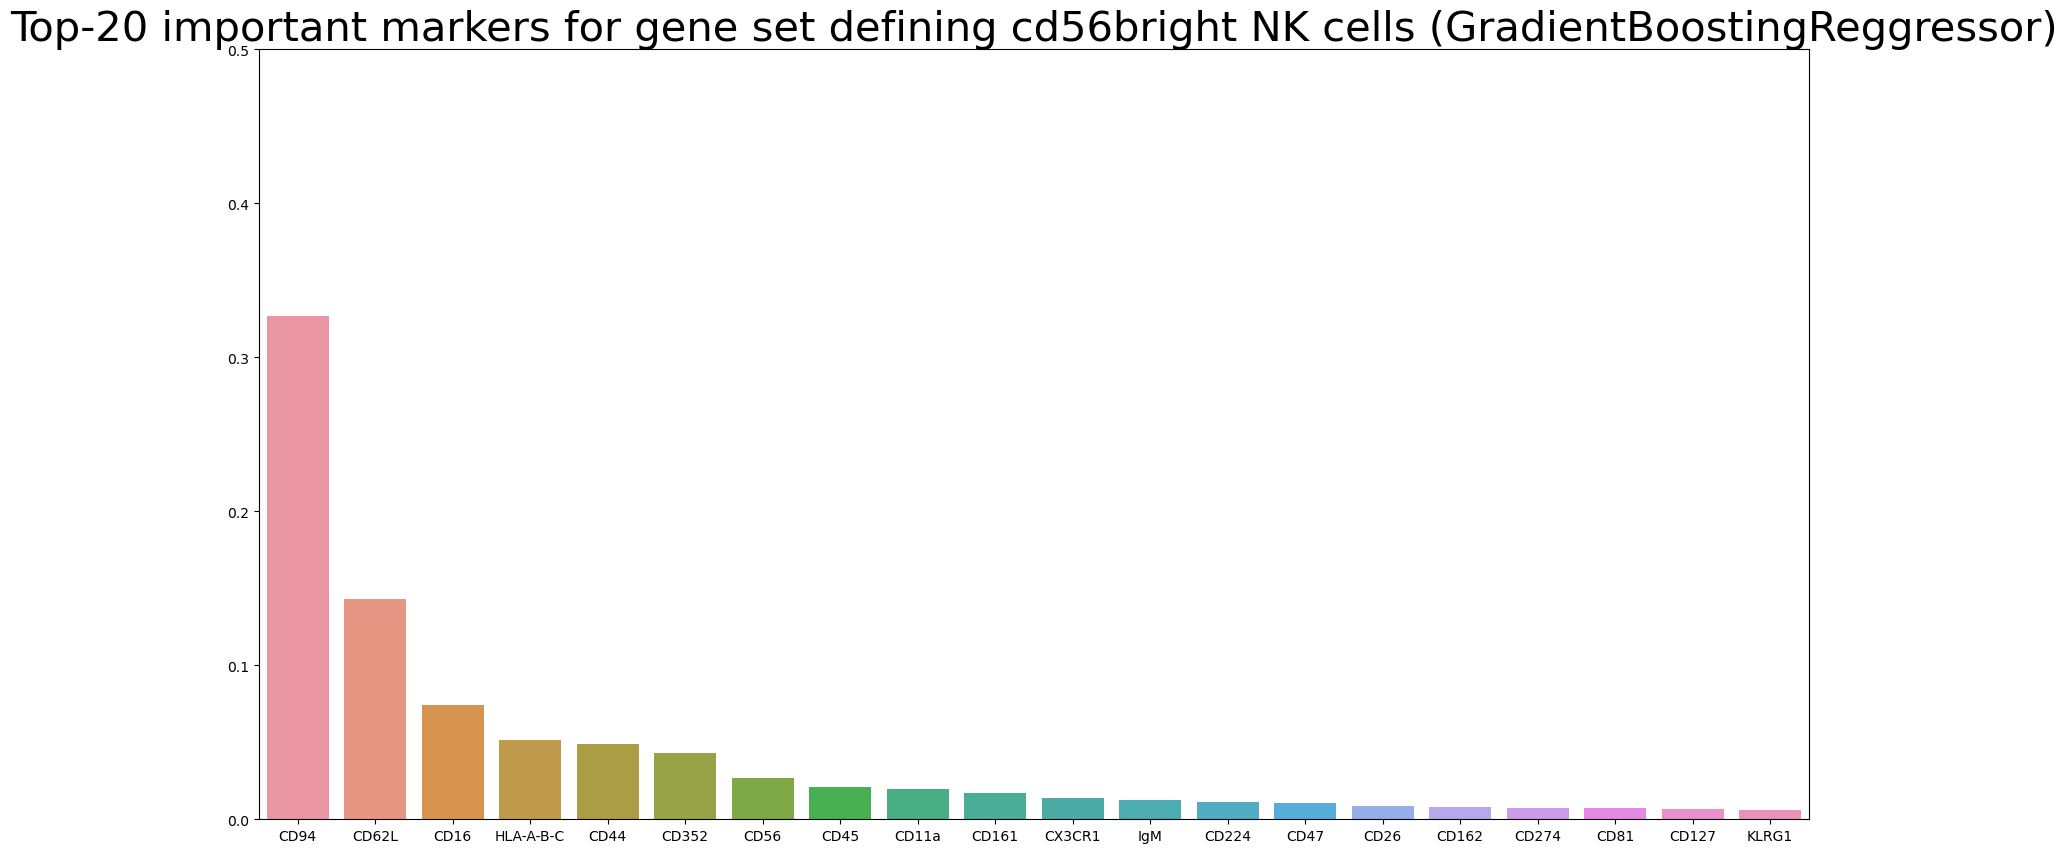

In [56]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.5)
a=sb.barplot(data=importances_gbr_top)

plt.title("Top-20 important markers for gene set defining cd56bright NK cells (GradientBoostingReggressor)", fontsize = 30) ;



## 4. CatBoostRegressor

In [66]:
from catboost import CatBoostRegressor

X = df.iloc[:, 1:]
y = df['marker_score']

mean_train_score = []

params= {'depth': [6,8,10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations'    : [30, 50, 100]
                 }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(CatBoostRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train, verbose=0 )
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_cb = result.best_estimator_
y_pred = best_model_cb.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.03 R2 score: 0.51


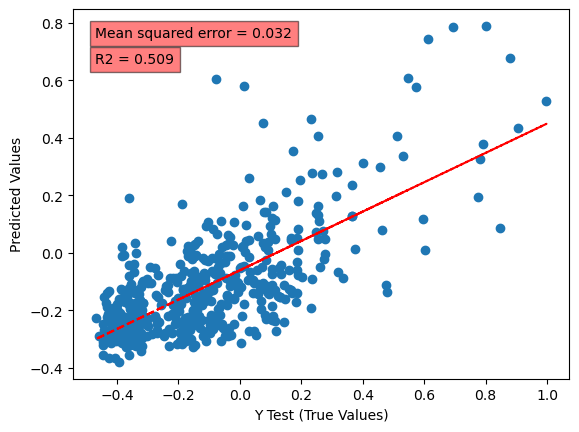

In [68]:
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

plt.annotate("Mean squared error = {:.3f}".format(MSE), (-0.47, 0.75), bbox = dict(facecolor = 'red', alpha = 0.5))

plt.annotate("R2 = {:.3f}".format(R2), (-0.47, 0.66), bbox = dict(facecolor = 'red', alpha = 0.5))


plt.show()

<AxesSubplot: xlabel='marker_score', ylabel='Density'>

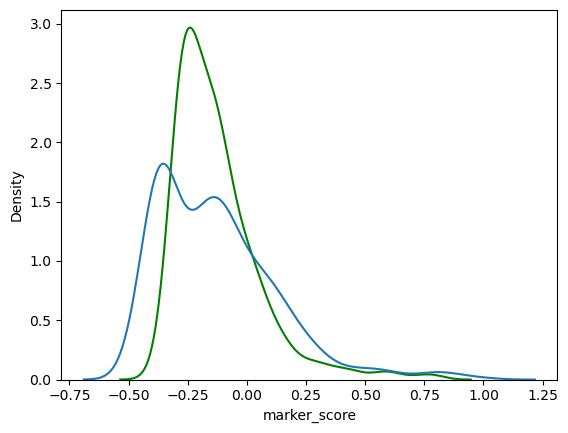

In [34]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [35]:
importances_cb = best_model_cb.feature_importances_
importances_cb = pd.Series(importances_cb, index=prot.columns)
importances_cb=importances_cb.sort_values(ascending=False)

print(importances_cb.head(10))

CD94         29.543653
CD62L         9.658502
CD16          6.346618
CD56          3.661246
CD44          3.395511
CD352         3.169537
CD161         2.405239
CD26          1.935067
CD224         1.857182
HLA-A-B-C     1.807438
dtype: float64


In [36]:
#df from the top 20 important markers
importances_cb=pd.DataFrame(importances_cb)
importances_cb_top=importances_cb[0:20]
importances_cb_top=importances_cb_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


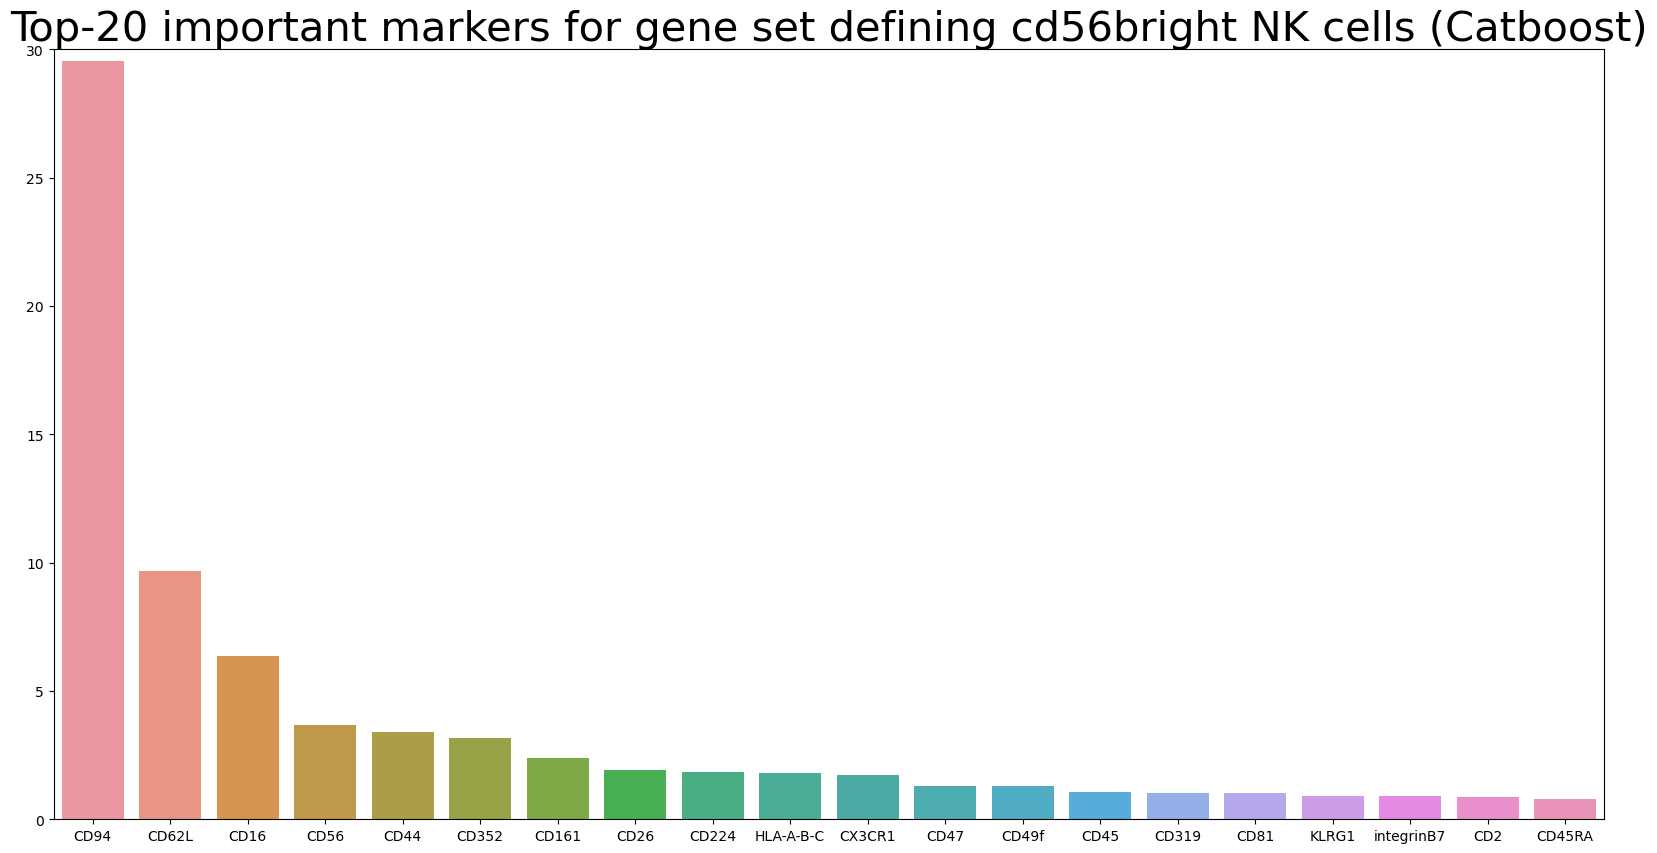

In [37]:
plt.figure(figsize=(20,10))
plt.ylim(0,30)
a=sb.barplot(data=importances_cb_top)

plt.title("Top-20 important markers for gene set defining cd56bright NK cells (Catboost)", fontsize = 30) ;




## 5. UMAP visualization

In [34]:
markers_prot = ['CD94', 'CD62L', 'CD16', 'CD56', 'CD44', 'CD352', 'CD161', 'CD26', 'CD224_prot']

In [22]:
#selecting one sample from Neurips

sample =adata_neurips[adata_neurips.obs['POOL'] == "s4d1"].copy()


In [23]:
#selecting only NK cells using Neurips annotations, one sample

sample_nk = sample[(sample.obs['cell_type'] == "NK") | (sample.obs['cell_type'] == "NK CD158e1+")].copy()   



In [24]:
#Computing a neighborhood of observations using latent space

sc.pp.neighbors(sample_nk, use_rep="X_totalVI")   

sc.tl.umap(sample_nk)

In [25]:
#saving protein information

prot=sample_nk.obsm['protein_expression_clr_neurips']

In [26]:
#Some genes have same names, so _prot added after some proteins

prot=prot.rename(columns={'CD2': 'CD2_prot', 'CD83': 'CD83_prot', 'HLA-E': 'HLA-E_prot', 'CX3CR1': 'CX3CR1_prot', 'CD52': 'CD52_prot','CD69': 'CD69_prot', 'CD226':'CD226_prot', 'CD47': 'CD47_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})

In [27]:
#adding protein information to obs

a = sample_nk.obs
b = prot

adata_sample=pd.concat([a, b], axis=1)
sample_nk.obs=adata_sample

In [28]:
sample_nk

AnnData object with n_obs × n_vars = 665 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47_prot', 'CD48', 'CD40', 'CD154', 'CD52_prot', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16'

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


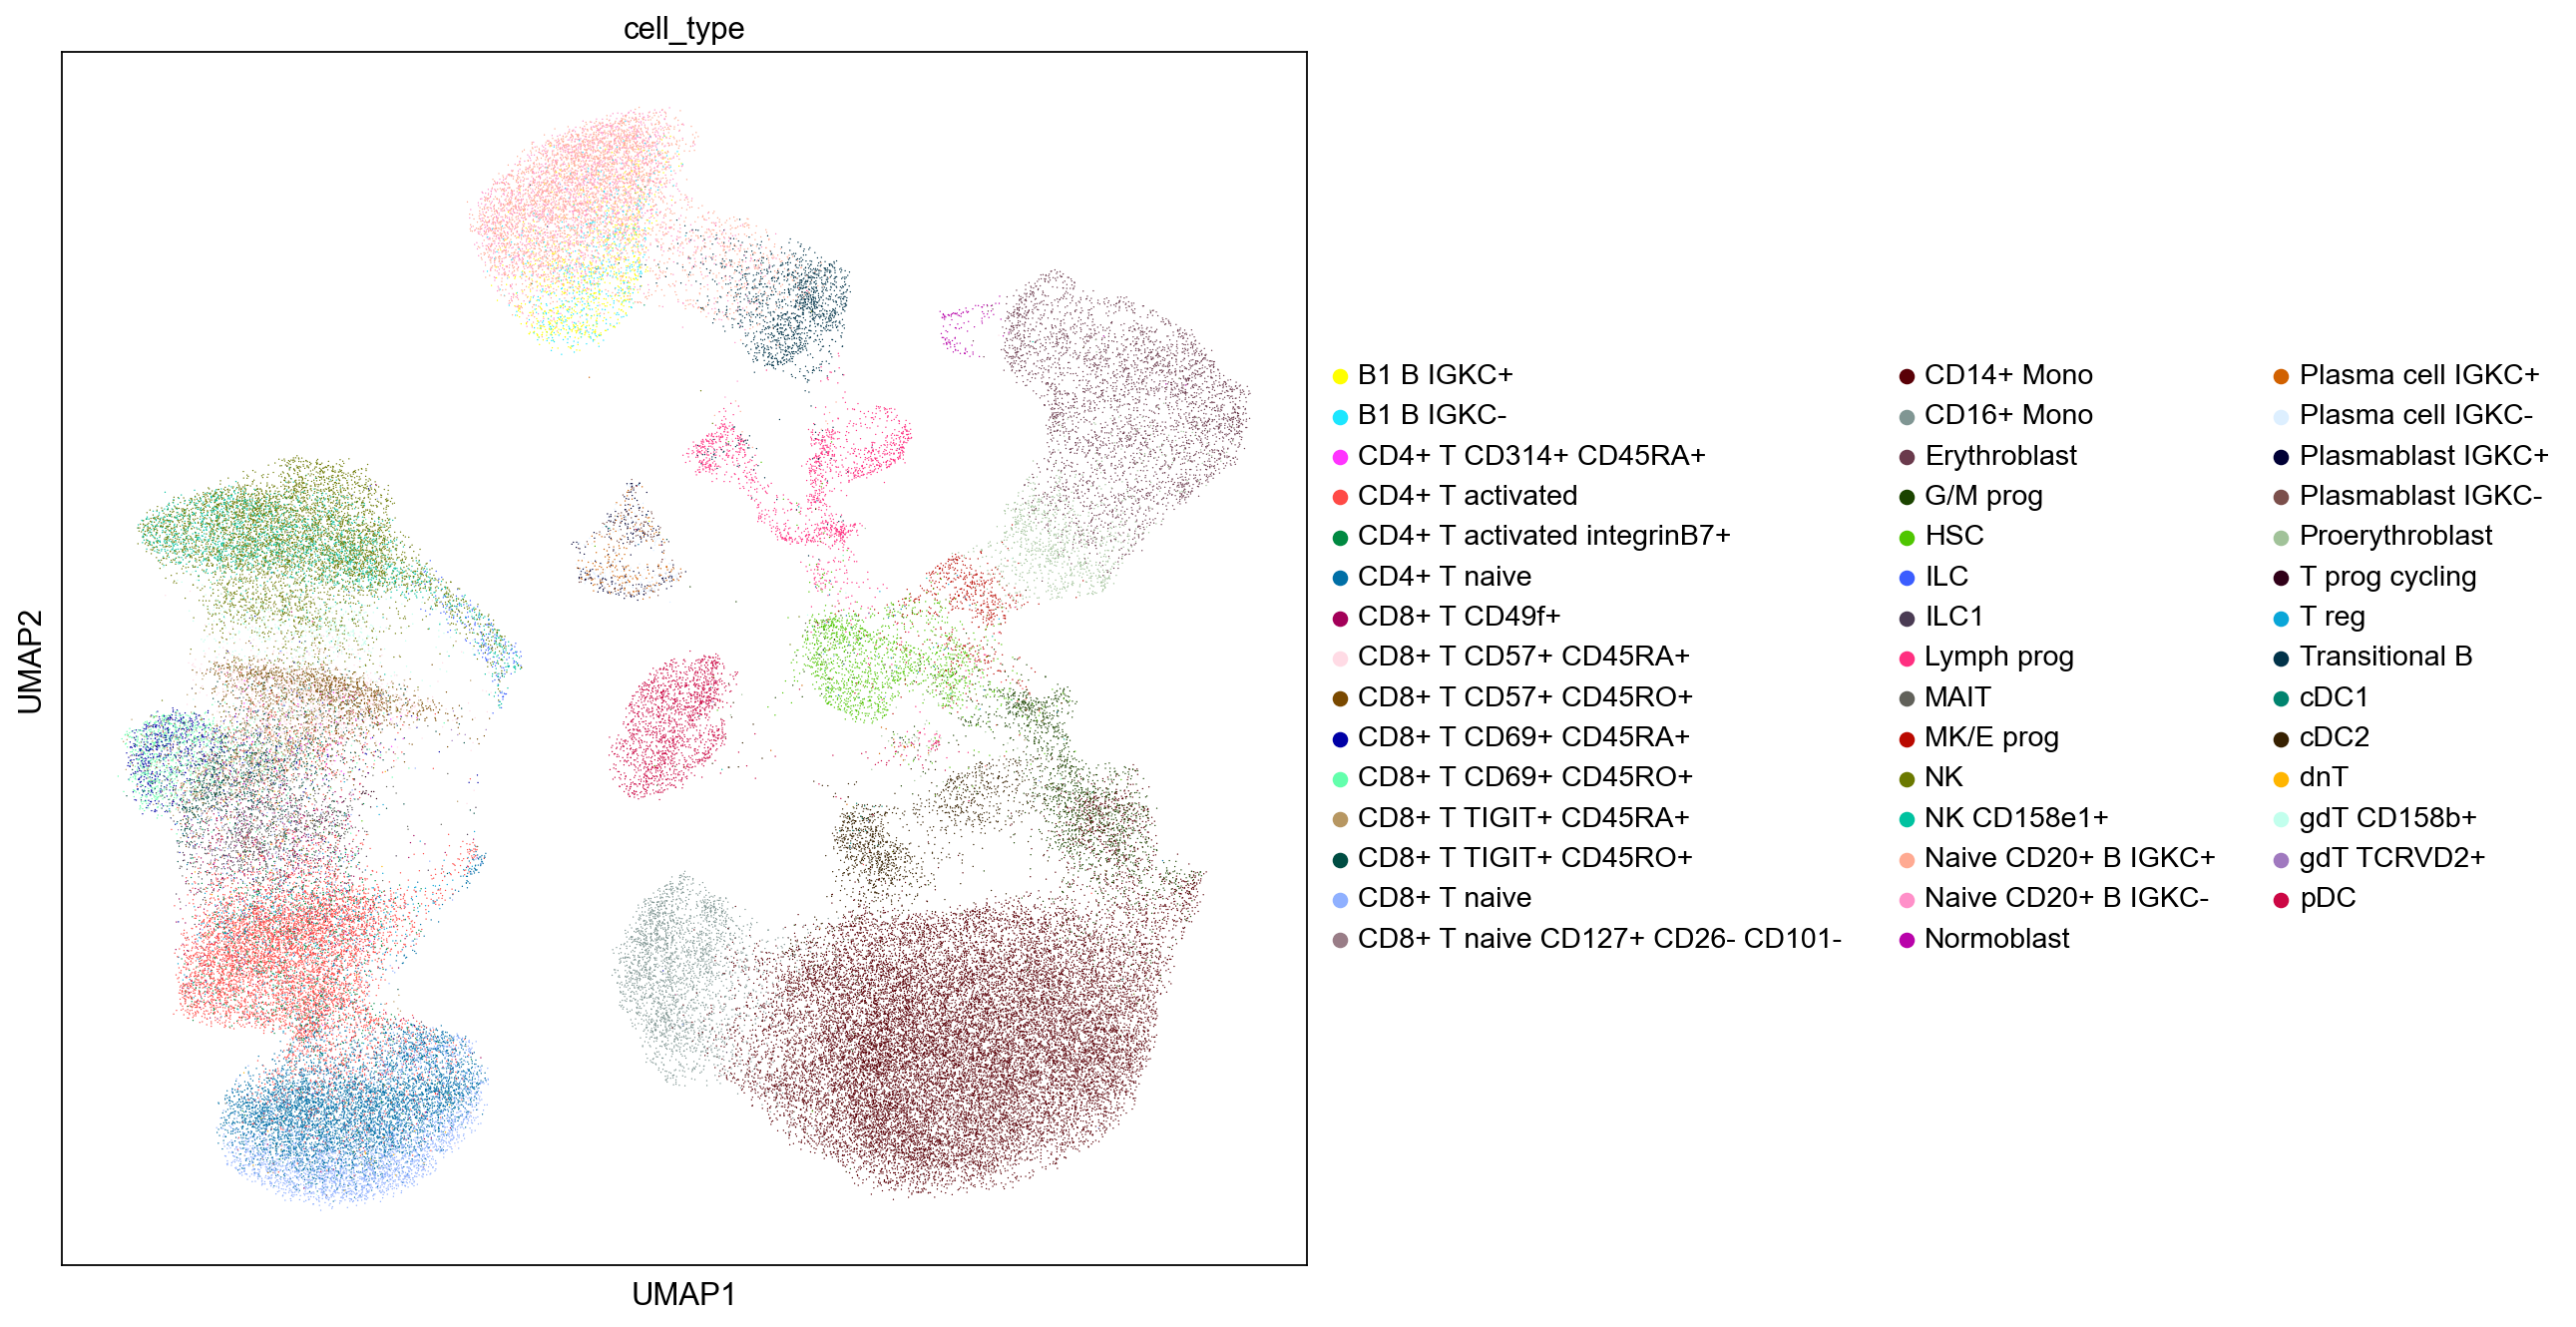

In [41]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_neurips, color = ['cell_type'])

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


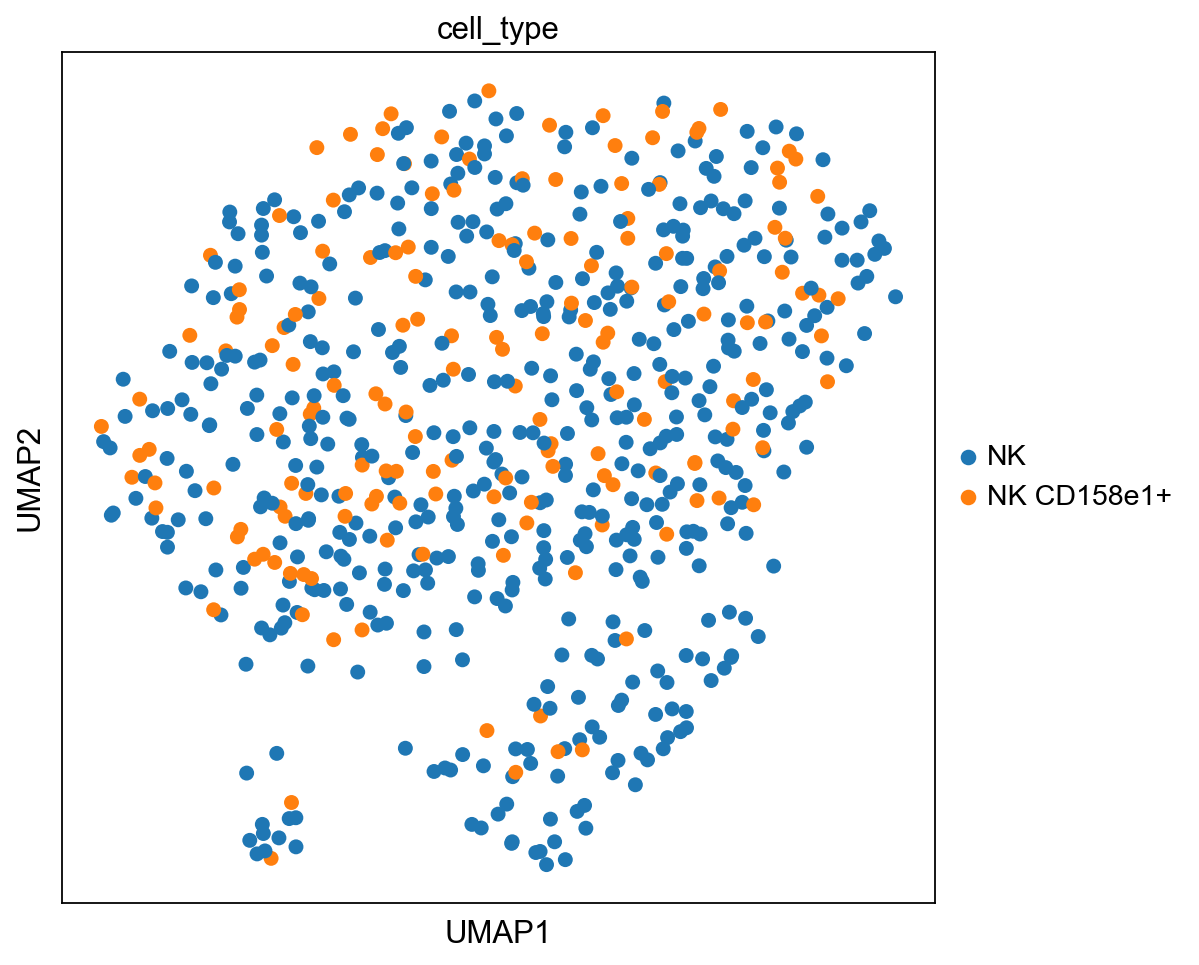

In [32]:
#only one sample

sc.set_figure_params(figsize=(7, 7))

sc.pl.umap(sample_nk, color = ['cell_type'])

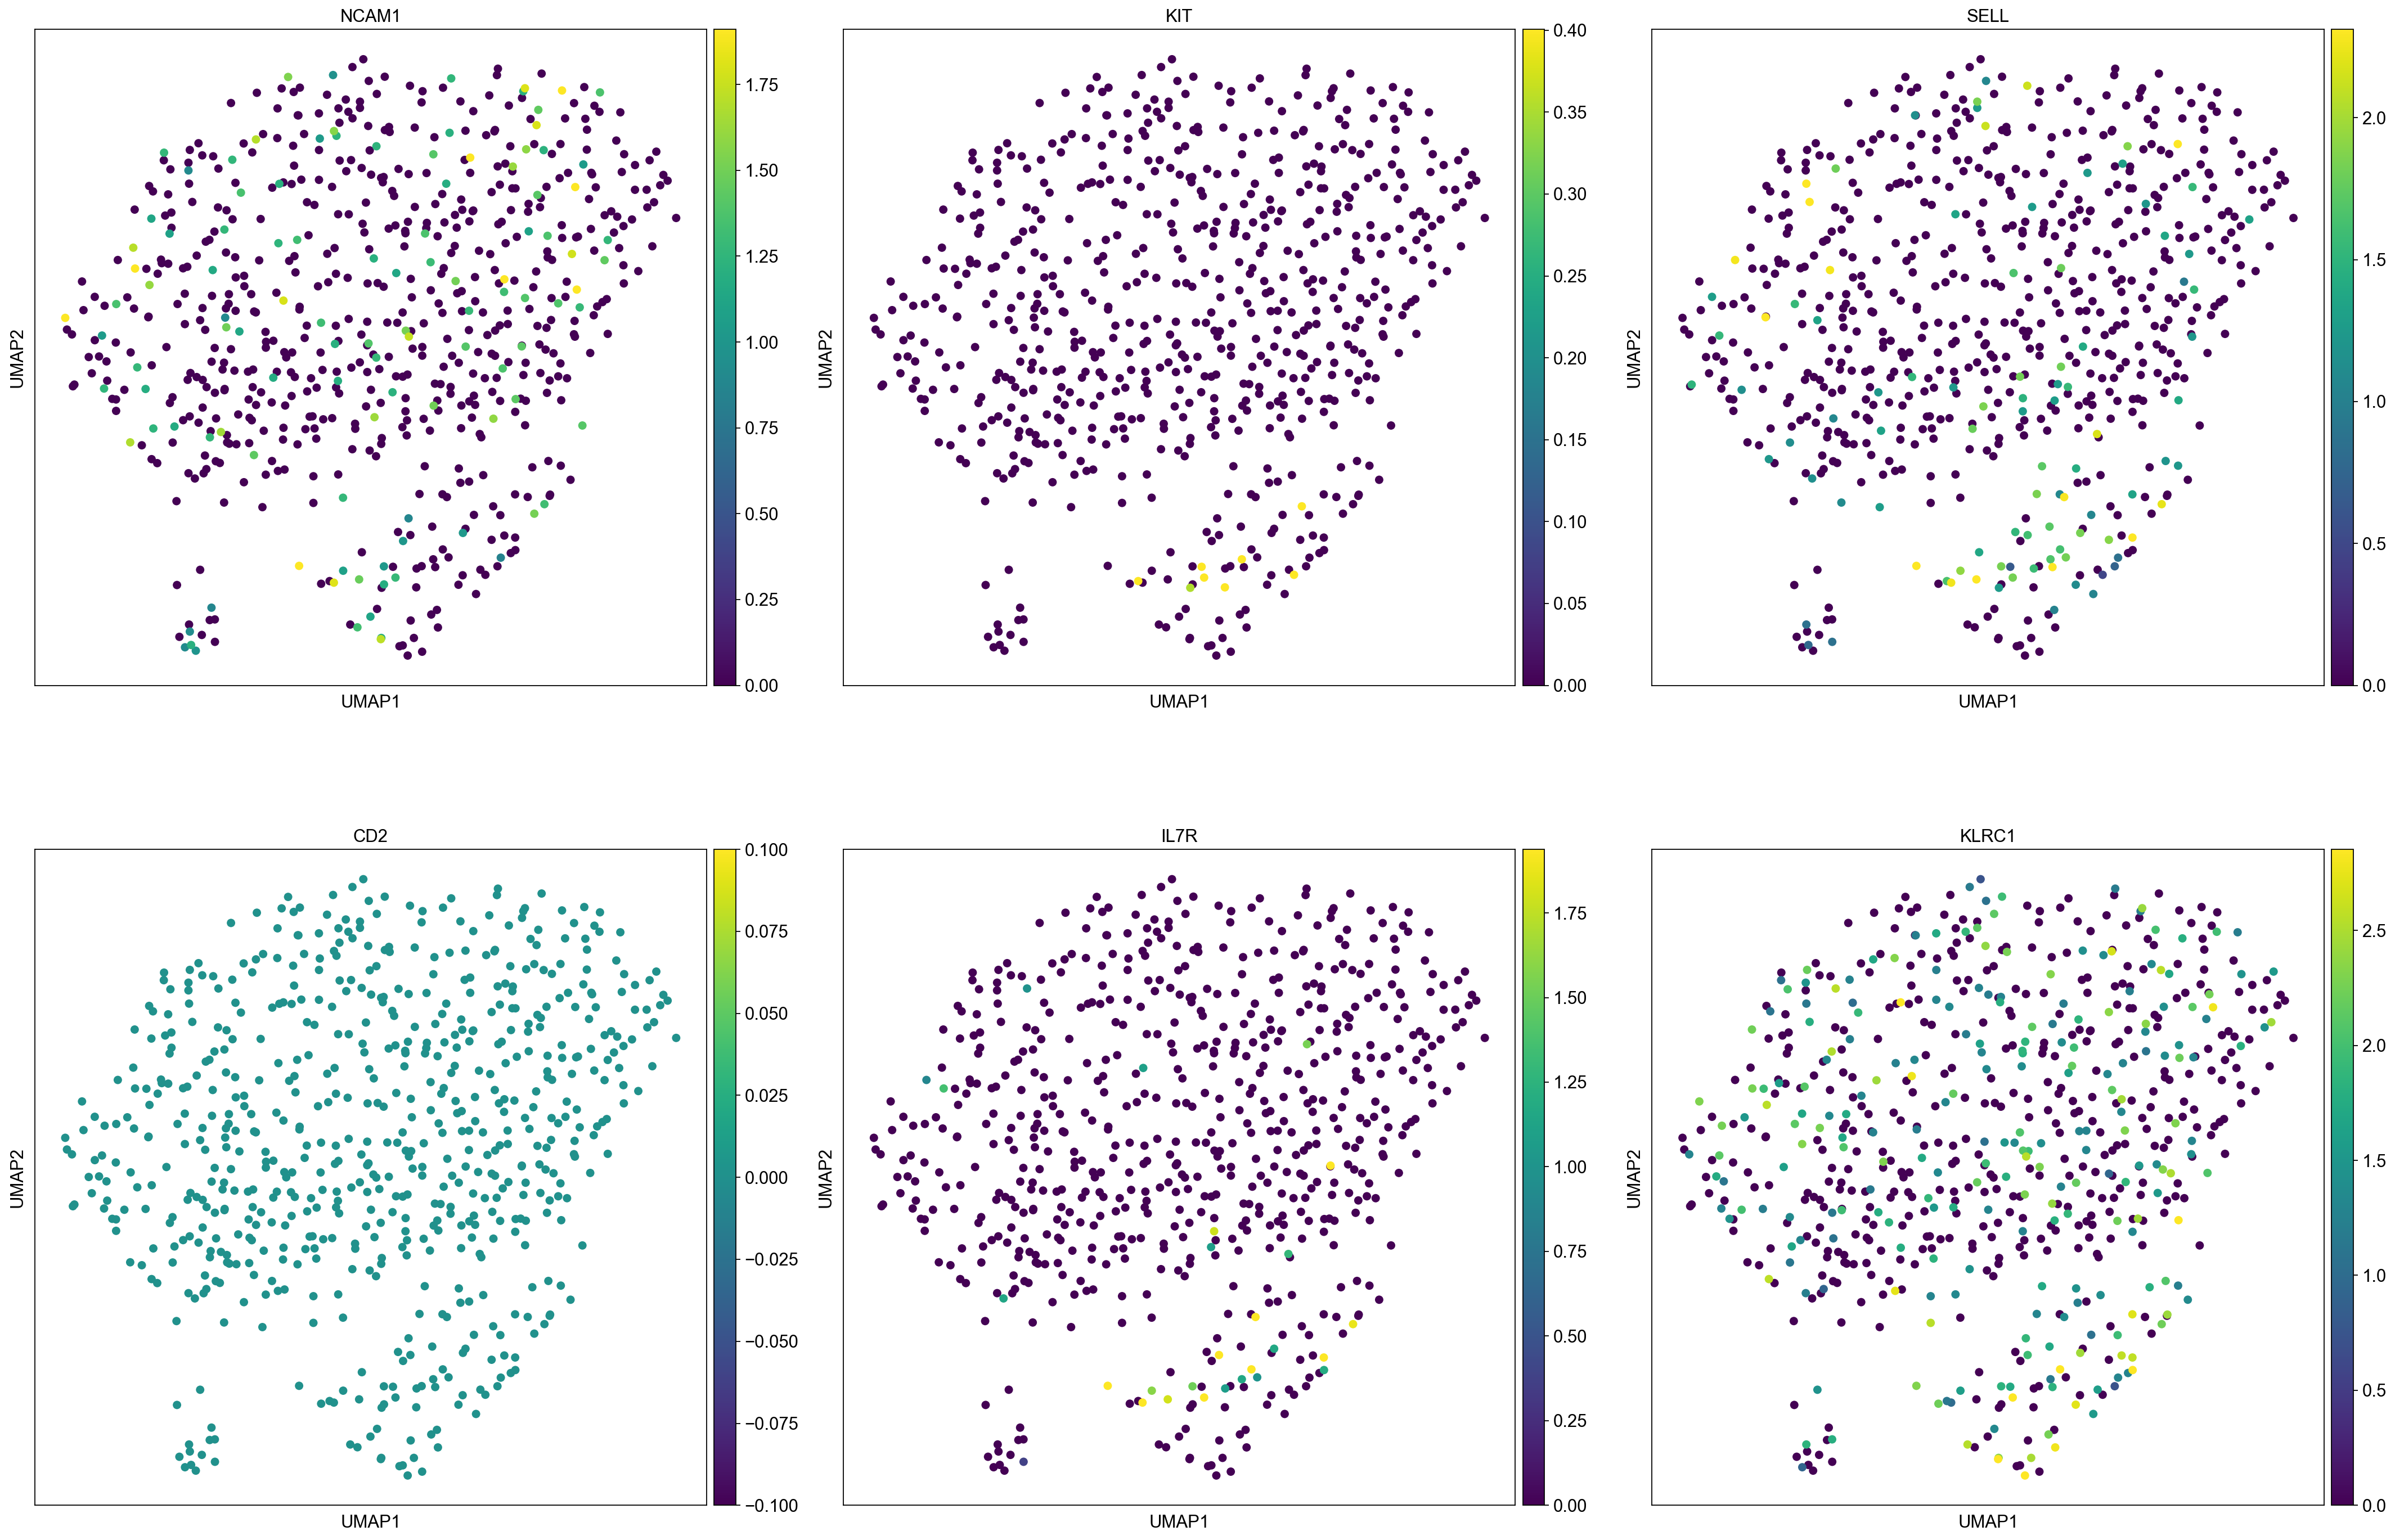

In [31]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample_nk, color = markers,  vmax="p99", ncols = 3)

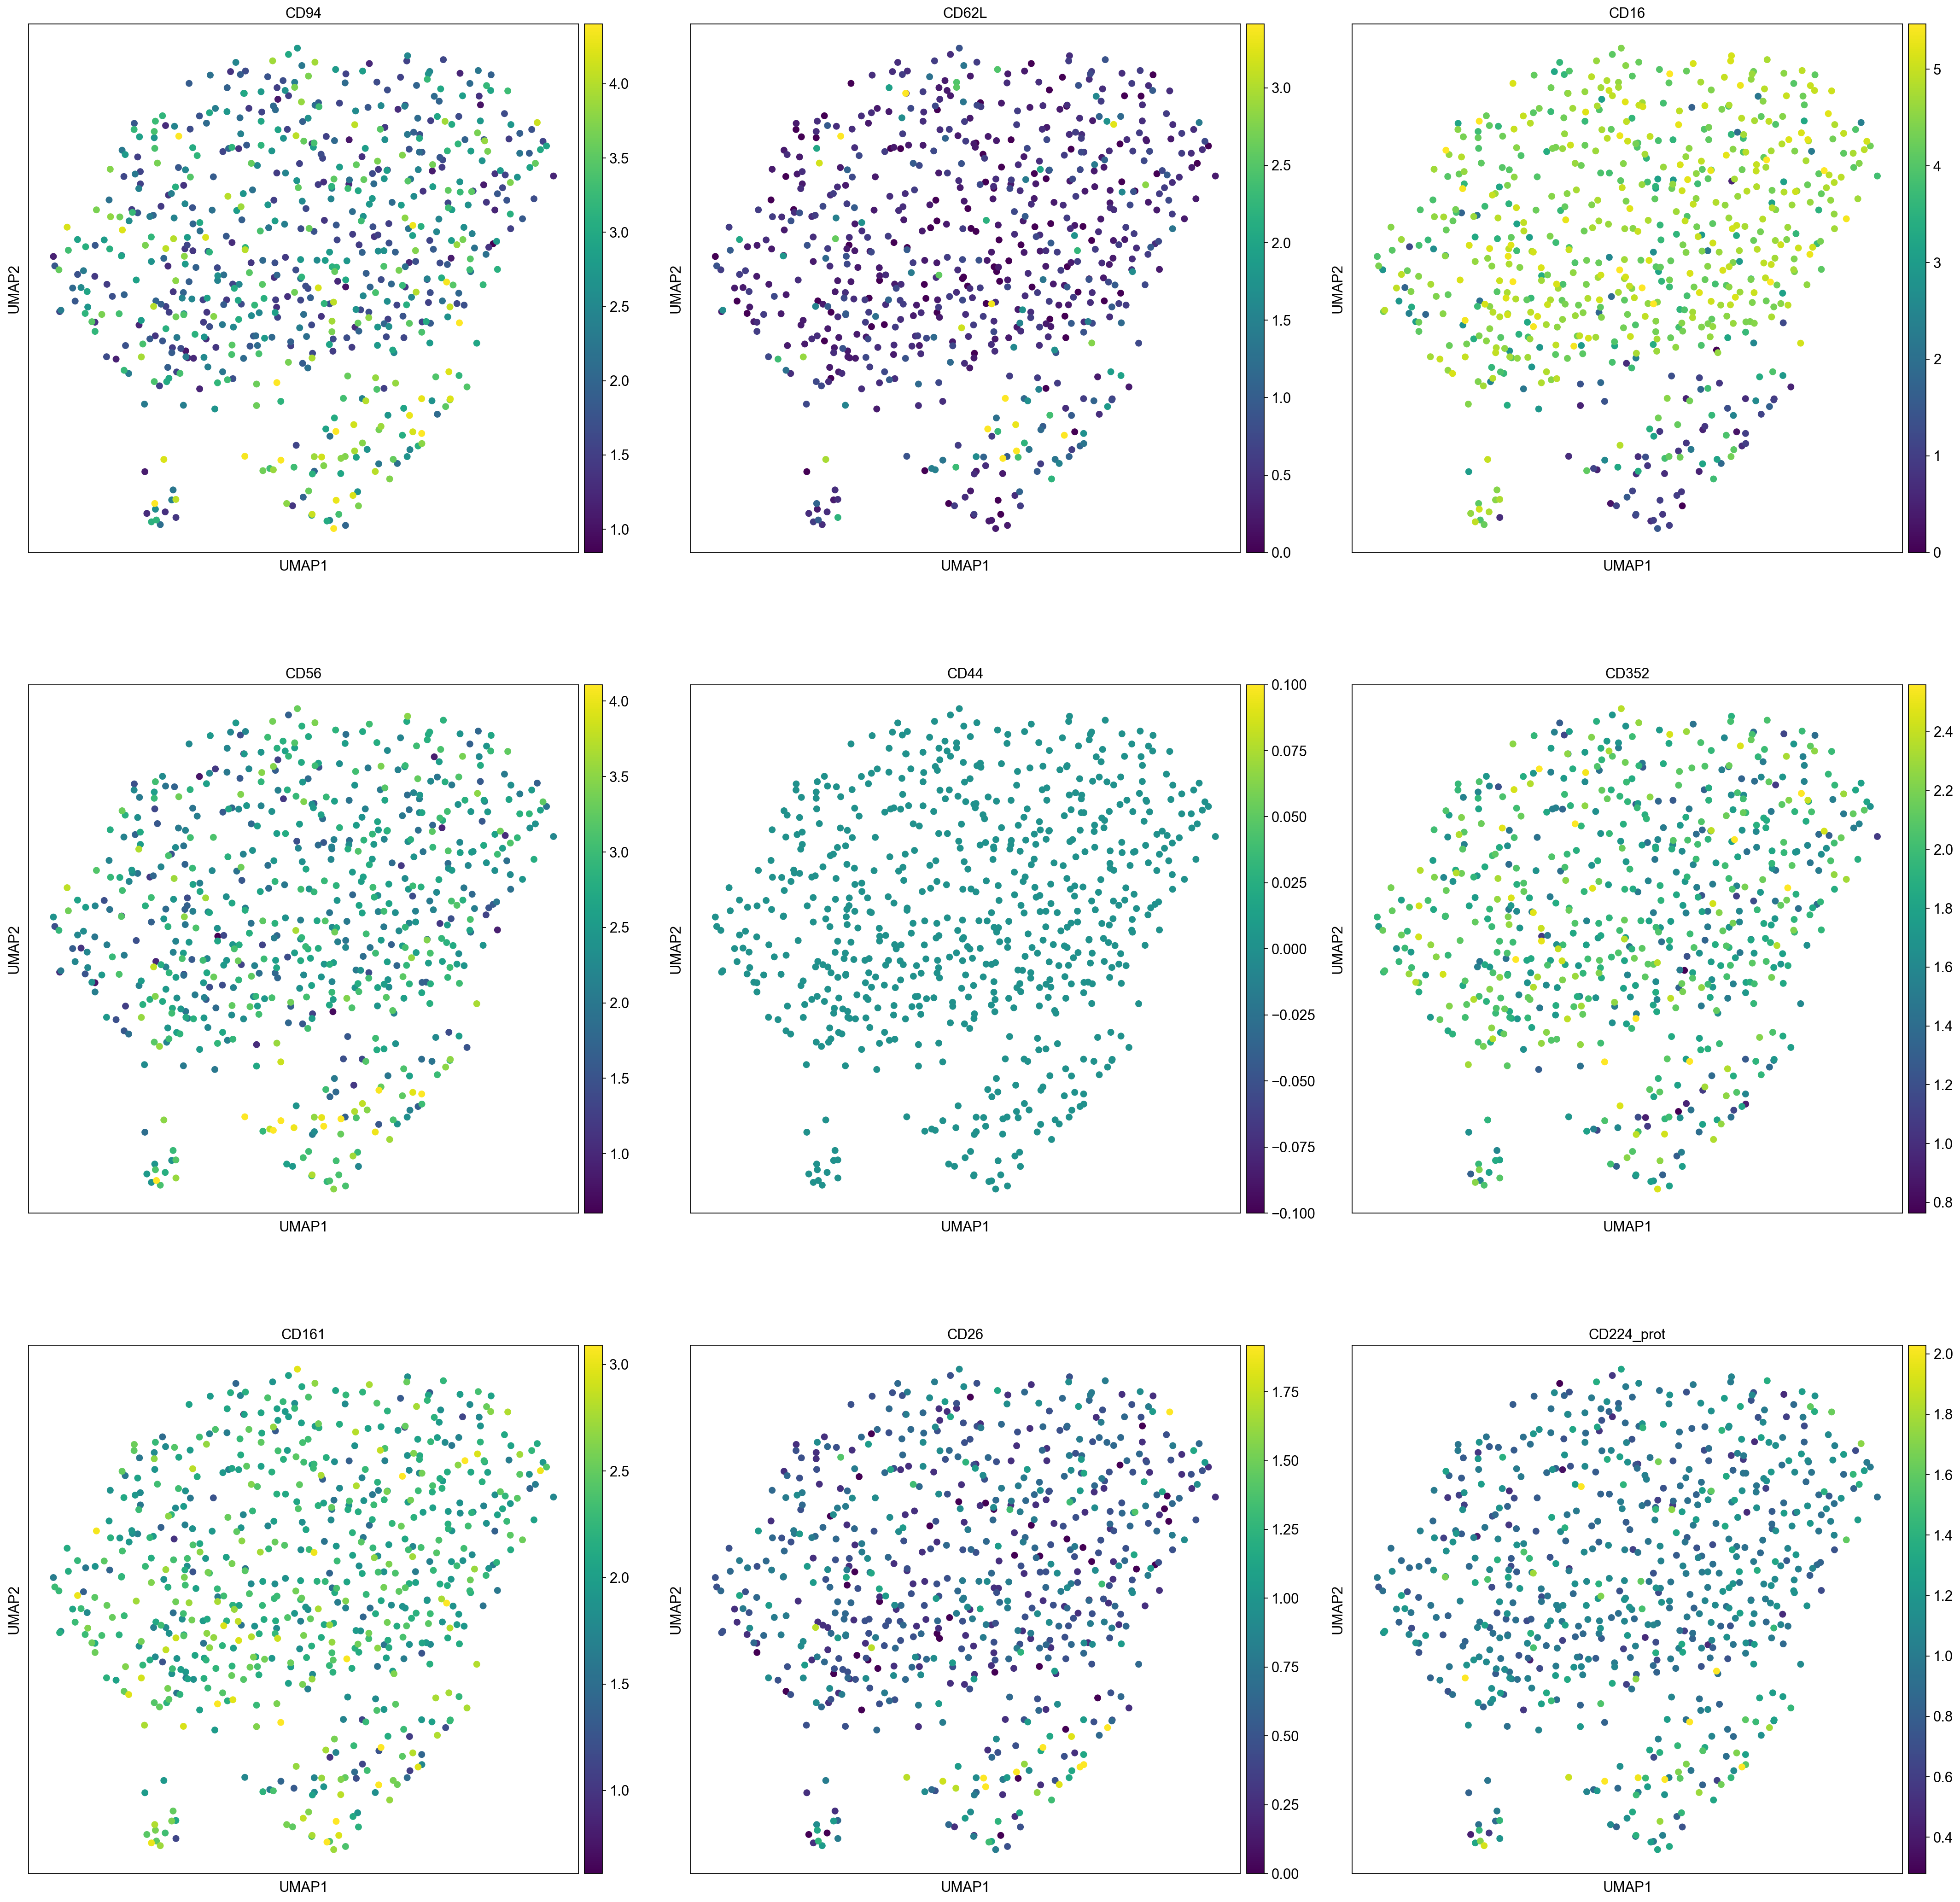

In [35]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample_nk, color = markers_prot,  vmax="p99", ncols = 3)

Markers above are important features (surface proteins) for CD56bright NK cells identified by CatBoostReggressor.